In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import mlflow

In [2]:
os.chdir("/home/ubuntu/projects/Predict_Ride_Duration/")

In [3]:

mlflow.set_tracking_uri("sqlite:///mlflow.sqlite.db")
mlflow.set_experiment("nyc-taxi-duration-experiment-0527")

<Experiment: artifact_location='/home/ubuntu/projects/Predict_Ride_Duration/mlruns/1', creation_time=1685176902134, experiment_id='1', last_update_time=1685176902134, lifecycle_stage='active', name='nyc-taxi-duration-experiment-0527', tags={}>

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe('./01-intro/data/train/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./01-intro/data/val/green_tripdata_2021-02.parquet')

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [21]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

/tmp/ipykernel_2374/29126828.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2374/29126828.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


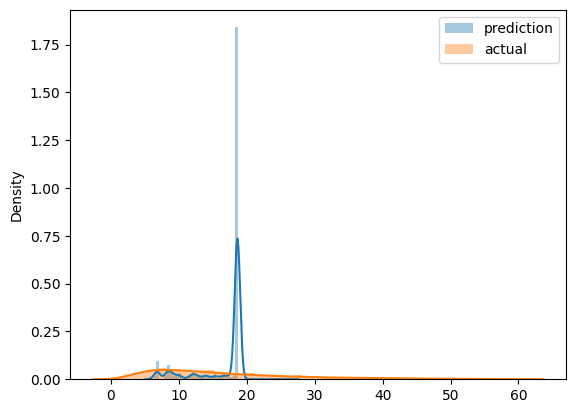

<Figure size 640x480 with 0 Axes>

In [10]:
with mlflow.start_run():

    mlflow.set_tag("dev", "challenger")

    mlflow.log_param("train-data", "./01-intro/data/train/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data", "./01-intro/data/val/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    sns.distplot(y_pred, label='prediction')
    sns.distplot(y_train, label='actual')

    plt.legend()
    plt.show()
    plt.savefig("Train-vs-pred target distribution.png")
    mlflow.log_artifact("Train-vs-pred target distribution.png")